In [551]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from cycler import cycler
from astropy.io import fits

In [548]:
#Change default matplotlib rcParams. View available settings via mpl.rcParams.keys()
#https://stackoverflow.com/questions/4971269/how-to-pick-a-new-color-for-each-plotted-line-within-a-figure-in-matplotlib
mpl.rcParams['figure.figsize'] = (13,8)
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['#f44242', '#f49841', '#eff248', '#bcf252', '#7cf151', 
                                                   '#5def89', '#5cefc3', '#5ce5ef', '#5fa8e8', '#4658e2',
                                                   '#6a45c6', '#8b44c6', '#b644c6', '#c644a7', '#c64471',
                                                   '#c64450'])
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['#f44242', '#eff248', '#7cf151', 
                                                   '#5ce5ef', '#5fa8e8', 
                                                   '#8b44c6', '#c644a7', '#c64471',
                                                   '#c64450'])
mpl.rcParams['xtick.minor.bottom'] = True
mpl.rcParams['xtick.minor.visible'] = True

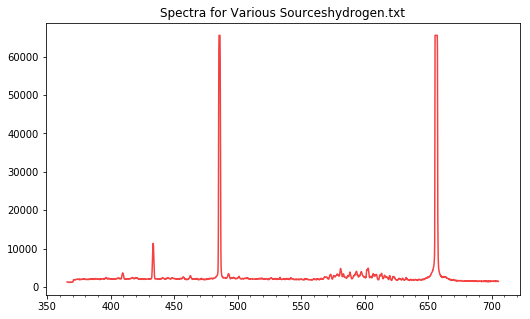

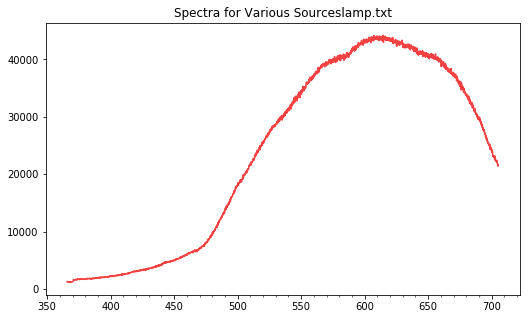

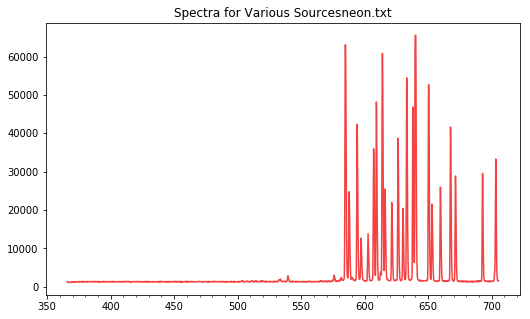

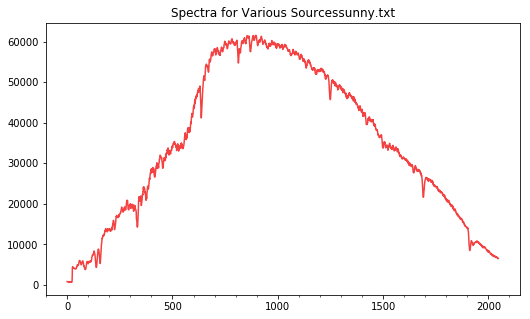

CPU times: user 1.13 s, sys: 187 ms, total: 1.32 s
Wall time: 765 ms


In [7]:
%%time
#Spectra
path = './data/spectra/good/'
spectra_files = os.listdir(path)
for name in spectra_files:
    if '.txt' in name:
        data = np.genfromtxt(path+name, skip_header=17, skip_footer=1)
        plt.plot(data[:,0], data[:,1])
        plt.title('Spectra for Various Sources'+name)
        plt.show()

In [321]:
%%time

path_s = './data/spectra/good/'
name_s = ['hydrogen', 'neon', 'lamp', 'sun', 'fluorescent']

hydrogen = np.genfromtxt(path_s + name_s[0] + '.txt', skip_header=17, skip_footer=1)
neon = np.genfromtxt(path_s + name_s[1] + '.txt', skip_header=17, skip_footer=1)
lamp = np.genfromtxt(path_s + name_s[2] + '.txt', skip_header=17, skip_footer=1)
sun = np.genfromtxt(path_s + name_s[3] + '.txt', skip_header=17, skip_footer=1)
fluorescent = np.genfromtxt(path_s + name_s[4] + '.txt', skip_header=17, skip_footer=1)

CPU times: user 42.7 ms, sys: 1.63 ms, total: 44.3 ms
Wall time: 43.4 ms


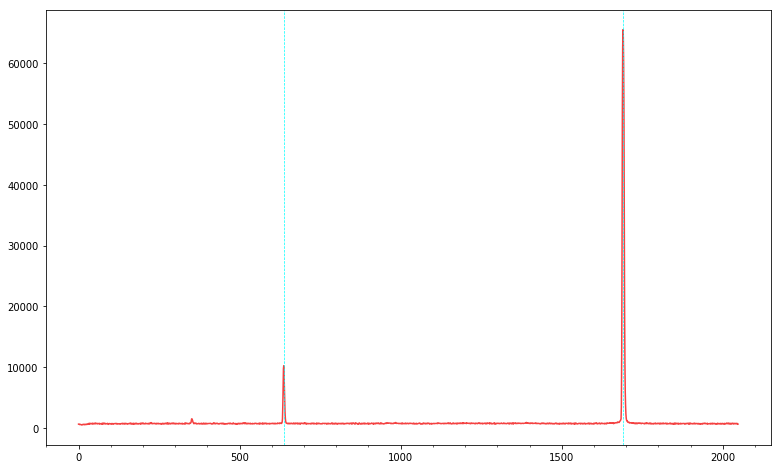

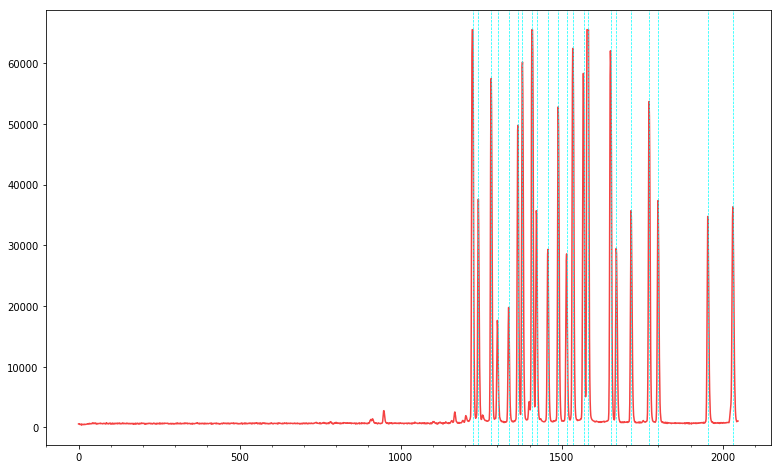

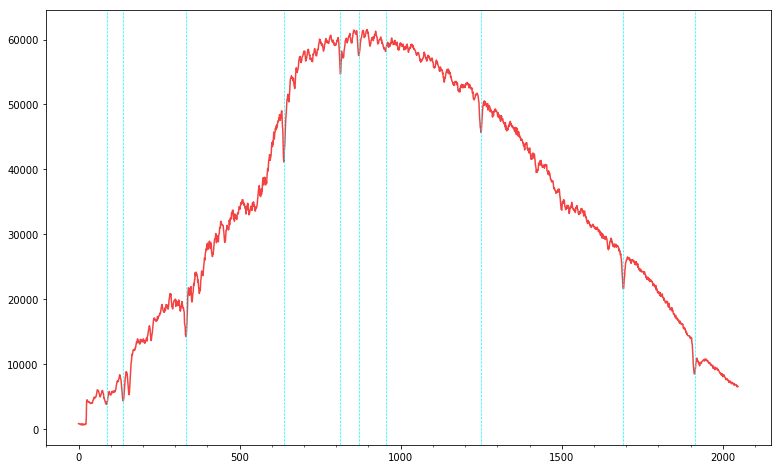

In [330]:
''' Finds and returns an array of peaks in data.
'''
def find_peaks(data, n=4, positive=True, threshold=0):
    peaks = []
    if positive:
        for i in np.arange(len(data) - 2*n)+n:
            if data[i,1] >= threshold and data[i,1] >= max(max(data[i-n:i,1]), max(data[i+1:i+1+n,1])):
                peaks.append((data[i,0], data[i,1]))
    else:
        for i in np.arange(len(data) - 2*n)+n:
            if data[i,1] <= min(min(data[i-n:i,1]), min(data[i+1:i+1+n,1])):
                peaks.append((data[i,0], data[i,1]))
    return np.array(peaks)

''' Finds the range of the peak by finding the Full Width at Half Maximum of the peak. 
'''
def find_fwhm(data, peaks, deviation=7):
    fwhm = []
    every = []
    for i in range(len(peaks)):
        every.append([])
        fwhm.append([])
        hm = peaks[i,1]/2
        where = np.where(data >= hm)
        for point in where[0]:
            if deviation >= np.abs(data[point, 0] - peaks[i,0]):
                every[i].append(data[point,0])
        fwhm[i].append((min(every[i]), max(every[i])))
    pairs = []
    for item in fwhm:
        pairs.append((item[0][0], item[0][1]))
    fwhm = np.unique(pairs, axis=0)
    return np.array(fwhm)

''' Finds the centroids using the weighted average formula. 
'''
def find_centroids(data, n=4, positive=True, threshold=10000):
    fwhm = find_fwhm(data, find_peaks(data, n=n, positive=positive, threshold=threshold))
    centroids = []
    for r in fwhm:
        i = int(r[0])
        j = int(r[1] + 1)
        number = np.sum(data[i:j,0] * data[i:j,1]) / np.sum(data[i:j,1])
        centroids.append((number, data[int(number),1]))
    return np.array(centroids)

''' Plots the centroids as vertical lines, superimposed on data.
'''
def plot_centroids(data, centroids):
    plt.plot(data[:,0], data[:,1])
    for centroid in centroids[:,0]: plt.axvline(x=centroid, linestyle='dashed', linewidth=0.7, color='cyan')
    plt.show()


centroids_h = find_centroids(hydrogen)
centroids_n = find_centroids(neon)
peaks_s = find_peaks(sun, n=40, positive=False)

plot_centroids(hydrogen, centroids_h)
plot_centroids(neon, centroids_n)
plot_centroids(sun, peaks_s)

[1.50970004e-01 4.01326759e+02]


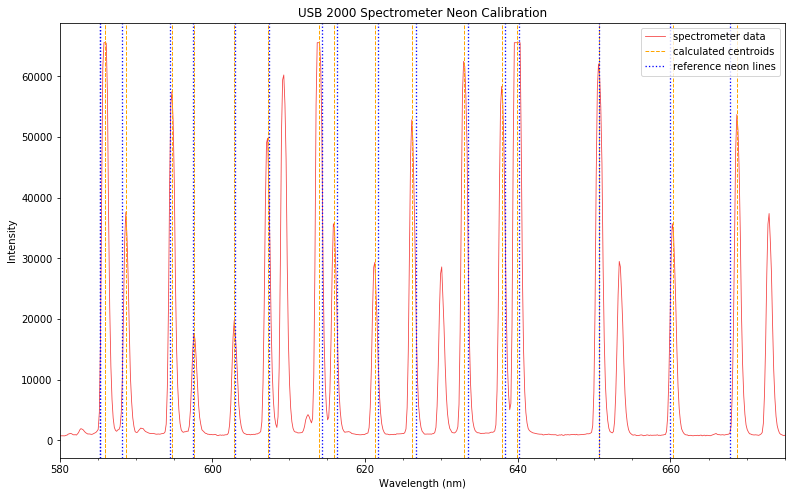

In [472]:
''' Finds the optimal fit parameters based on the provided matrix.
'''
def linear_fit(data):
    n = len(data)
    m = np.sum(data[:,0])*np.sum(data[:,1]) - n*np.sum(data[:,0]*data[:,1])
    m /= np.sum(data[:,0])**2 - n * np.sum(data[:,0]**2)
    c = np.sum(data[:,0])*np.sum(data[:,0]*data[:,1]) - np.sum(data[:,0]**2)*np.sum(data[:,1])
    c /= np.sum(data[:,0])**2 - n * np.sum(data[:,0]**2)
    return np.array((m, c))

''' A linear regression model. 
'''
def linear(x, a, b):
    return a*x + b

wave_n = np.array([585.24879, 587.28275, 588.18952, 594.48342, 596.5471, 597.46273, 
                   597.5534, 602.99969, 607.43377, 614.30626, 616.35939, 621.72812, 
                   626.6495, 633.44278, 638.29917, 640.2248, 650.65281, 659.89529, 
                   667.82762])

pixel_n = []
for i in [0,1,2,3,4,5,7,8,9,10,12,13,14,15,17,18]:
    pixel_n.append(centroids_n[i,0])
pixel_n = np.array(pixel_n)
    
wave_nf = []
for i in [0,2,3,5,7,8,9,10,11,12,13,14,15,16,17,18]:
    wave_nf.append(wave_n[i])
wave_nf = np.array(wave_nf)

cal_n = []
for i in range(len(pixel_n)):
    cal_n.append((pixel_n[i], wave_nf[i]))
cal_n = np.array(cal_n)

fit_n = linear_fit(cal_n)

#Plot the calibration lines and compare them to the known values
plt.plot(linear(neon[:,0], fit_n[0], fit_n[1]), neon[:,1], linewidth=0.8, label='spectrometer data')
for centroid in linear(pixel_n, fit_n[0], fit_n[1]): plt.axvline(x=centroid, linestyle='dashed', 
                                                                 linewidth=1.0, color='orange')
plt.axvline(x=linear(pixel_n[0], fit_n[0], fit_n[1]), linestyle='dashed', linewidth=1.0, color='orange',
            label='calculated centroids')
for wave in wave_nf: plt.axvline(x=wave, linestyle='dotted', linewidth=1.3, color='blue')
plt.axvline(x=wave_nf[0], linestyle='dotted', linewidth=1.3, color='blue', label='reference neon lines')
plt.xlim(580,675)
plt.ylabel('Intensity')
plt.xlabel('Wavelength (nm)')
plt.title('USB 2000 Spectrometer Neon Calibration')
plt.legend()
plt.savefig('graphs/neoncalib.png')

In [322]:
''' Plots the spectrum with appropriate wavelength mapping.
'''
def plot_spectrum(data, fit, filename, title, ylabel='Intensity', xlabel='Wavelength (nm)'):
    plt.plot(linear(data[:,0], fit[0], fit[1]), data[:,1], linewidth=0.8)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title('USB 2000 Spectrometer '+title)
    plt.savefig('graphs/'+filename+'.png')
    plt.clf()

plot_spectrum(hydrogen, fit_n, 'hydrogen', 'Hydrogen Spectrum')
plot_spectrum(neon, fit_n, 'neon', 'Neon Spectrum')
plot_spectrum(lamp, fit_n, 'lamp', 'Lamp Spectrum')
plot_spectrum(sun, fit_n, 'sun', 'Sun Spectrum')
plot_spectrum(fluorescent, fit_n, 'fluorescent', 'Fluorescent Lights Spectrum')

Filename: ./data/astro/GroupE/capella.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   (765, 510)   int16 (rescales to uint16)   
None


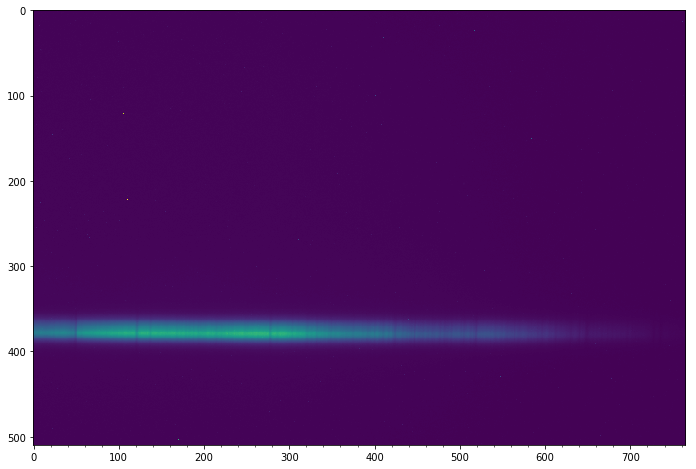

Filename: ./data/astro/GroupE/CCD Dark 2.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   (765, 510)   int16 (rescales to uint16)   
None


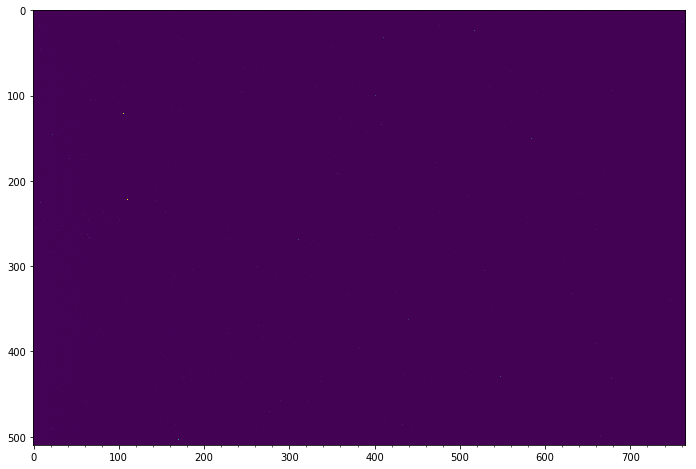

Filename: ./data/astro/GroupE/CCD Dark 3.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   (765, 510)   int16 (rescales to uint16)   
None


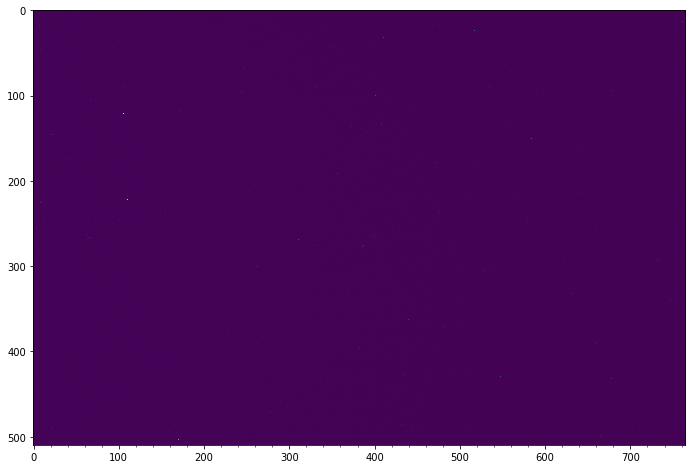

Filename: ./data/astro/GroupE/CCD Enif.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   (765, 510)   int16 (rescales to uint16)   
None


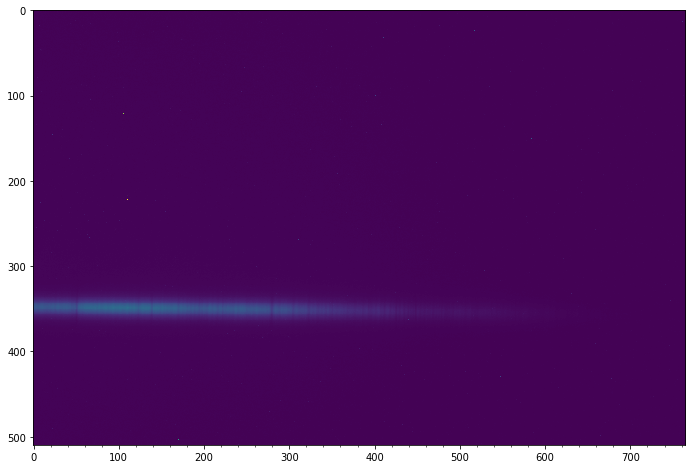

Filename: ./data/astro/GroupE/CCD Mars.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   (765, 510)   int16 (rescales to uint16)   
None


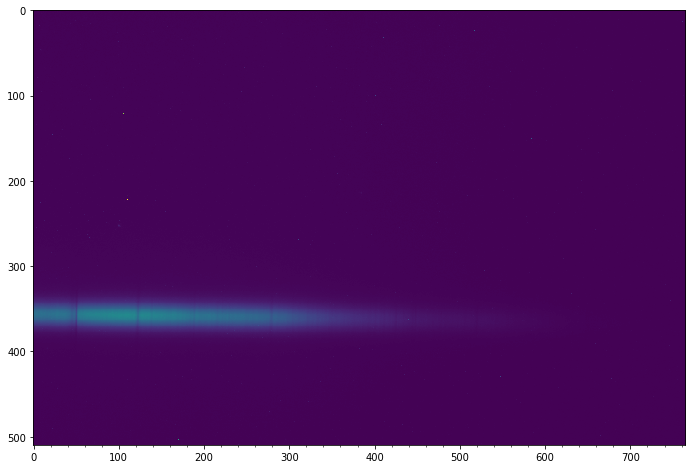

Filename: ./data/astro/GroupE/CCD Moon.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   (765, 510)   int16 (rescales to uint16)   
None


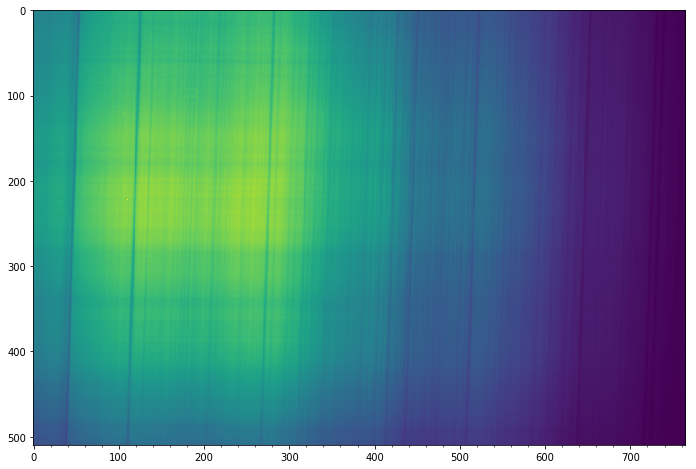

Filename: ./data/astro/GroupE/CCD Neon Calibration.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   (765, 510)   int16 (rescales to uint16)   
None


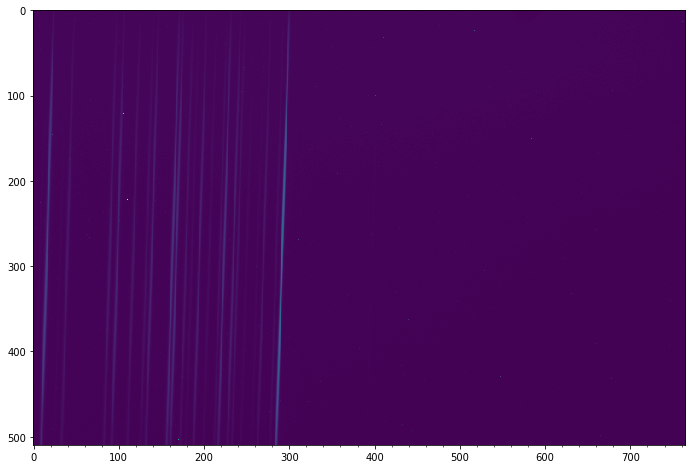

Filename: ./data/astro/GroupE/CCD Scheat.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   (765, 510)   int16 (rescales to uint16)   
None


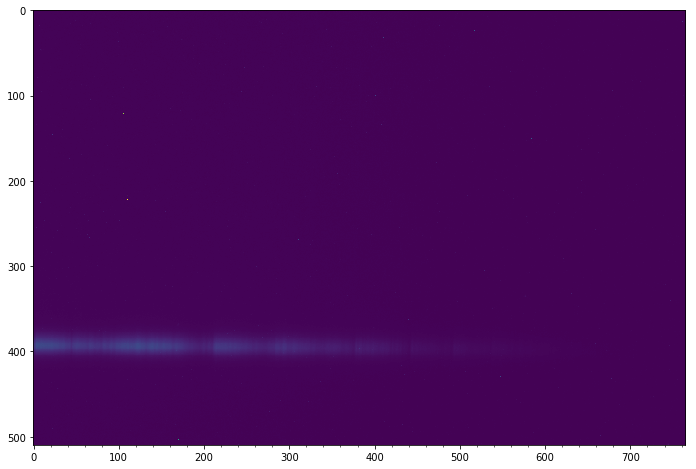

Filename: ./data/astro/GroupE/CCD Vega.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   (765, 510)   int16 (rescales to uint16)   
None


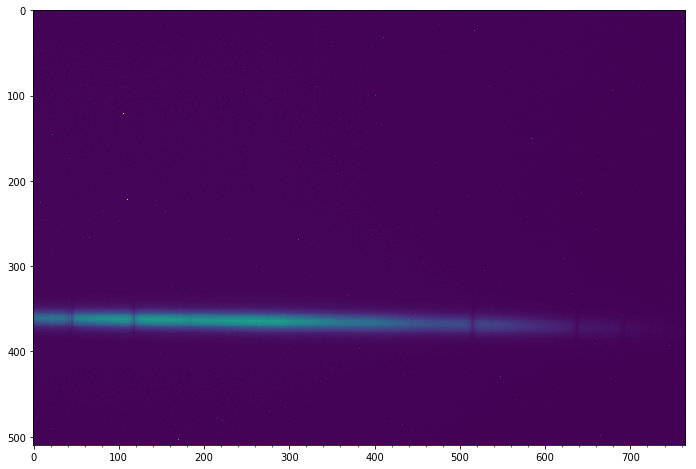

Filename: ./data/astro/GroupE/dark.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   (765, 510)   int16 (rescales to uint16)   
None


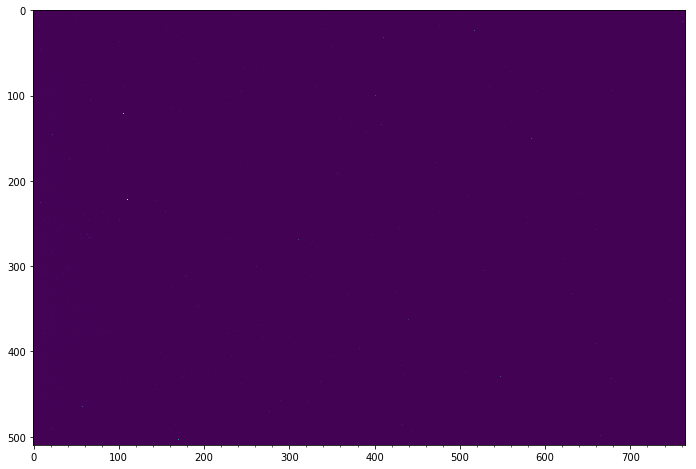

In [280]:
path_astro = './data/astro/GroupE/'
files_astro = os.listdir(path_astro)
for name in files_astro:
    if '.fit' in name:
        with fits.open(path_astro+name) as image:
            print(image.info())
            data = image[0].data
            plt.imshow(data)
            plt.show()

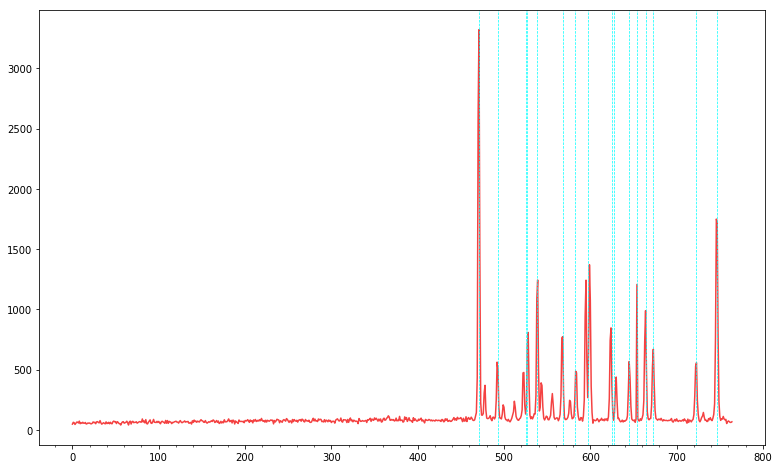

In [552]:
path_astro = './data/astro/GroupE/'

#Open the neon calibration frame
image_n = fits.open(path_astro+'neon.fit')
data_n = np.flip(image_n[0].data, axis=1)
brightest = np.where(data == np.max(np.max(data, axis=0)))
image_n.close()

#Calculate the master dark frame
dark = fits.open(path_astro+'dark.fit')
data_d = np.flip(dark[0].data, axis=1)
dark2 = fits.open(path_astro+'dark2.fit')
data_d2 = np.flip(dark2[0].data, axis=1)
dark3 = fits.open(path_astro+'dark3.fit')
data_d3 = np.flip(dark3[0].data, axis=1)
mdark = (data_d + data_d2 + data_d3)/3
mdarkrow = (data_d[brightest[0]][0] + data_d2[brightest[0]][0] + data_d3[brightest[0]][0])/3
dark.close()
dark2.close()
dark3.close()

#Find the centroids of the 1D neon spectrum
brow_n = data_n[brightest[0]][0] - mdarkrow
spectrum_n = []
for i in range(len(brow_n)):
    spectrum_n.append((i, brow_n[i]))
spectrum_n = np.array(spectrum_n)

centroids_na = find_centroids(spectrum_n, n=3, threshold=400)
plot_centroids(spectrum_n, centroids_na)

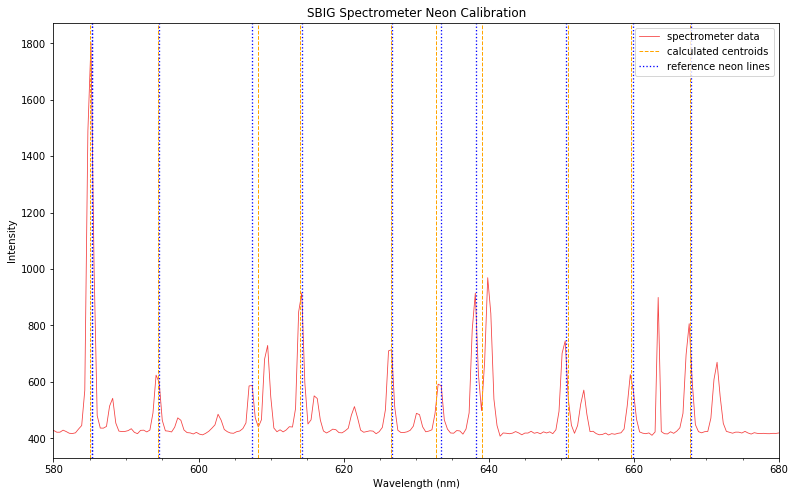

In [502]:
#Map the data to wavelength
pixel_na = []
for i in [0,1,2,4,5,6,7,8,10,12]:
    pixel_na.append(centroids_na[i,0])
pixel_na = np.array(pixel_na)

wave_na = []
for i in [0,2,5,6,9,10,11,13,14,15]:
    wave_na.append(wave_nf[i])
wave_na = np.array(wave_na)

cal_na = []
for i in range(len(pixel_na)):
    cal_na.append((pixel_na[i], wave_na[i]))
cal_na = np.array(cal_na)

fit_na = linear_fit(cal_na)

fit = (0.425, 385)
fit = fit_na
plt.plot(linear(spectrum_n[:,0], fit[0], fit[1]), linear(spectrum_n[:,1], fit[0], fit[1]), 
         linewidth=0.8, label='spectrometer data')
for centroid in linear(pixel_na, fit[0], fit[1]): plt.axvline(x=centroid, linestyle='dashed', 
                                          linewidth=1.0, color='orange')
for wave in wave_na: plt.axvline(x=wave, linestyle='dotted', linewidth=1.3, color='blue')
plt.axvline(x=linear(pixel_na[0], fit_n[0], fit_n[1]), linestyle='dashed', linewidth=1.0, color='orange',
            label='calculated centroids')
plt.axvline(x=wave_na[0], linestyle='dotted', linewidth=1.3, color='blue', label='reference neon lines')
plt.xlim(580,680)
plt.ylabel('Intensity')
plt.xlabel('Wavelength (nm)')
plt.title('SBIG Spectrometer Neon Calibration')
plt.legend()
plt.savefig('graphs/neoncaliba.png')

In [550]:
''' Graphs the 2D spectrum as well as the 1D spectrum of the collected data. 
'''
def graph_spectrum(filename, title, fit, dark):
    image = fits.open(path_astro+filename+'.fit')
    data = np.flip(image[0].data, axis=1) - dark
    image.close()
    plt.imshow(data)
    plt.colorbar()
    plt.xlabel('Pixel Number')
    plt.ylabel('Pixel Number')
    plt.title('SBIG Spectrum for '+title)
    plt.savefig('graphs/astro/'+filename+'.png')
    plt.clf()
    brightest = np.where(data == np.max(np.max(data, axis=0)))
    brow = data[brightest[0]][0]
    spectrum = []
    for i in range(len(brow)):
        spectrum.append((i, brow[i]))
    spectrum = np.array(brow)
    plt.plot(linear(spectrum, fit[0], fit[1]))
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity')
    plt.title('SBIG Spectrum for '+title)
    plt.savefig('graphs/astro/spectra/'+filename+'.png')
    plt.clf()
    return linear(spectrum, fit[0], fit[1])

s_m = graph_spectrum('moon', 'Moon', fit, mdark)
s_c = graph_spectrum('capella', 'Capella', fit, mdark)
s_M = graph_spectrum('mars', 'Mars', fit, mdark)
s_e = graph_spectrum('enif', 'Enif', fit, mdark)
s_s = graph_spectrum('scheat', 'Scheat', fit, mdark)
s_v = graph_spectrum('vega', 'Vega', fit, mdark)

#Graph all the spectra, superimposed. 
plt.plot(s_m, label='Moon')
plt.plot(s_c, label='Capella')
plt.plot(s_M, label='Mars')
plt.plot(s_e, label='Enif')
plt.plot(s_s, label='Scheat')
plt.plot(s_v, label='Vega')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.title('SBIG Spectrum for all sources')
plt.legend()
plt.savefig('graphs/astro/spectra/all.png')
plt.clf()

#Graph all the spectra, superimposed, without the moon, which is too bright. 
plt.plot(s_c, label='Capella')
plt.plot(s_M, label='Mars')
plt.plot(s_e, label='Enif')
plt.plot(s_s, label='Scheat')
plt.plot(s_v, label='Vega')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.title('SBIG Spectrum for all sources')
plt.legend()
plt.savefig('graphs/astro/spectra/allm.png')
plt.clf()